In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import torch
import os.path as osp
import seaborn as sb
from matplotlib import pyplot as plt
import glob
import utils
from yaml import Loader, load
import pickle5 as pickle
from matplotlib import cm
import itertools as it
import networkx as nx
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from pyproj import Proj, transform
from shapely import geometry
import geoplot as gplt

In [323]:
def load_cv_results(models, base_dir, year=2017, trials=5, ext='', fluxes=False):
    results = dict()
    bird_scales = dict()
    all_fluxes = dict()
    radar_idx = dict()
    
    for i, (m, d) in enumerate(models.items()):

        # load predictions
        model_dir = osp.join(base_dir, m)
        result_list = []
        radar_idx_list = []
        for t in range(1, trials+1):
            file = osp.join(model_dir, f'test_{year}', d, f'trial_{t}', f'results{ext}.csv')
            print(file)
            if osp.isfile(file):
                df = pd.read_csv(file)
                df['trial'] = t
                result_list.append(df)
            
            radar_path = osp.join(osp.dirname(file), 'radar_index.pickle')
            if osp.isfile(radar_path):
                with open(radar_path, 'rb') as f:
                    radar_idx_list.append(pickle.load(f))
        radar_idx[m] = radar_idx_list
        results[m] = pd.concat(result_list)
        
        print(f'successfully loaded results for {m}')
        
        # load fluxes
        if fluxes and 'Flux' in m:
            m_fluxes = [dict(), dict()]
            for t in range(1, trials+1):
                sub_dir = osp.join(model_dir, f'test_{year}', d, f'trial_{t}')
                          
                with open(osp.join(sub_dir, f'radar_fluxes{ext}.pickle'), 'rb') as f:
                    m_fluxes[0][t] = pickle.load(f)
                          
                with open(osp.join(sub_dir, f'model_fluxes{ext}.pickle'), 'rb') as f:
                    m_fluxes[1][t] = pickle.load(f)
    
            all_fluxes[m] = m_fluxes

    return results, bird_scales, all_fluxes, radar_idx

In [3]:
def compute_rmse(m, results, groupby='fold', threshold=0, km2=True):
    
    ext = '_km2' if km2 else ''
        
    results[f'squared_error{ext}'] = results[f'residual{ext}'].pow(2)
    df = results.query(f'missing == 0 & gt{ext} >= {threshold}')
    rmse = df.groupby(groupby)[f'squared_error{ext}'].aggregate(np.mean).apply(np.sqrt)
    rmse = rmse.reset_index(name='rmse')
    rmse['model'] = m
    
    return rmse

In [4]:
def plot_fluxes(voronoi, G, all_fluxes, results, fold=0, model=1, context=24, horizon=64, bird_scale=1, 
                net_fluxes=False, abm=False, ax=None, crs=None, max_flux=0):

    G_new = nx.DiGraph()
    G_new.add_nodes_from(list(G.nodes(data=True)))

    if abm:
        f = np.concatenate([f[..., :horizon+1] for f in all_fluxes.values()], axis=-1)
        mask = np.concatenate([results.query(f'seqID == {i+encoder}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes))])
    else:
        print(len(all_fluxes[fold]), results.horizon.unique())
        if model:
            f = torch.cat([f for f in all_fluxes[fold].values()], dim=-1).detach().numpy()
        else:
            f = torch.cat([f[..., context:context+horizon] for f in all_fluxes[fold].values()], dim=-1).detach().numpy()
        mask = np.concatenate([results.query(f'seqID == {i} & horizon >= {context}').groupby('horizon').night.all().values 
                           for i in range(len(all_fluxes[fold]))])


    #radars = results.radar.unique()
    radars = voronoi.radar.values
    for i, ri in enumerate(radars):
        for j, rj in enumerate(radars):
            val = np.nanmean(f[j,i,mask]) #- np.nanmean(f[i,j,mask].detach().numpy())
            val2 = np.nanmean(f[i,j,mask])
            #print(val)
            if net_fluxes:
                val = val - val2
            if val > 0 and i !=j :
                boundary1 = ('boundary' in ri) and ('boundary' in rj)
                boundary2 = voronoi.query(f'radar == "{ri}" or radar == "{rj}"')['boundary'].all()
                #if val > 0 and not boundary1 and not boundary2:
#                 if not boundary1 and not boundary2:
#                     print(i, ri, j, rj, val, val2)
                if not boundary1 and not boundary2:
                    G_new.add_edge(j, i, flux=val)

    

    coord_df = gpd.GeoDataFrame(dict(radar = voronoi.radar, 
                                 geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi.iterrows()]), 
                                crs='epsg:4326').to_crs(crs)
    pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
           (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}
#     pos = {ridx: (voronoi.query(f'radar == "{name}"').x.values[0], voronoi.query(f'radar == "{name}"').y.values[0]) for 
#            (ridx, name) in nx.get_node_attributes(G_new, 'radar').items()}

    fluxes = np.array(list(nx.get_edge_attributes(G_new,'flux').values()))
    edge_widths =  fluxes / (0.25 * np.abs(fluxes).max()) + 0.5

    node_colors = ['#999999' if 'boundary' in n_data['radar'] else '#0086b3' for n, n_data in G_new.nodes(data=True)]
    
    cmap = cm.get_cmap('YlOrRd')
    fluxes *= bird_scale
    max_flux = max(max_flux, fluxes.max())
    norm = plt.Normalize(0, max_flux)
    #print(fluxes.min(), fluxes.max())
    #print(nx.get_edge_attributes(G_new, 'flux'))
    edge_colors = cmap(norm(fluxes))

    if ax is None:
        fig, ax = plt.subplots(figsize=(12,8))
    options = {
        'arrowsize': 30,
    }
    nx.draw(G_new, pos=pos, with_labels=False, node_size=200, node_color=node_colors, width=edge_widths, ax=ax, 
            options={'arrowsize': edge_widths*100}, connectionstyle="arc3,rad=0.1", edge_color=edge_colors)
    if abm:
        ax.set(title='averaged simulated fluxes between radars')
    else:
        ax.set(title='averaged inferred fluxes between radars')
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    plt.colorbar(sm, label='bird density');
    return G_new, ax, max_flux

In [220]:

def compute_mse(model, experiment, results, groupby='trial', threshold=0, km2=True):
    ext = '_km2' if km2 else ''

    results[f'squared_error{ext}'] = results[f'residual{ext}'].pow(2)
    #results[f'squared_error{ext}'] = (results[f'gt{ext}'].apply(lambda x: np.log(x + 0.001)) - results[f'prediction{ext}'].apply(lambda x: np.log(x + 0.001))).pow(2)
    df = results.query(f'missing == 0 & gt{ext} >= {threshold}') # & night == 1')
    mse = df.groupby(groupby)[f'squared_error{ext}'].aggregate(np.mean) #.apply(np.sqrt)
    mse = mse.reset_index(name='rmse')
    mse['model'] = model
    mse['experiment'] = experiment

    return mse

def compute_pcc(model, experiment, results, groupby='trial', threshold=0, km2=True):
    ext = '_km2' if km2 else ''

    df = results.query(f'missing == 0 & gt{ext} >= {threshold}').dropna() # & night == 1')
    pcc = df.groupby(groupby)[['gt_km2', 'prediction_km2']].corr().iloc[0::2,-1]
    pcc = pcc.reset_index()
    pcc['model'] = model
    pcc['experiment'] = experiment

    return pcc

def compute_classification(model, experiment, results, groupby='trial', threshold=0, km2=True):
    ext = '_km2' if km2 else ''

    df = results.query(f'missing == 0').dropna()
    df['tp'] = (df[f'prediction{ext}'] > threshold) & (df[f'gt{ext}'] > threshold)
    df['fp'] = (df[f'prediction{ext}'] > threshold) & (df[f'gt{ext}'] < threshold)
    df['fn'] = (df[f'prediction{ext}'] < threshold) & (df[f'gt{ext}'] > threshold)
    df['tn'] = (df[f'prediction{ext}'] < threshold) & (df[f'gt{ext}'] < threshold)

    gr = df.groupby(groupby).aggregate(sum).reset_index()
    gr['accuracy'] = (gr.tp + gr.tn) / (gr.tp + gr.fp + gr.tn + gr.fn)
    gr['precision'] = gr.tp / (gr.tp + gr.fp)
    gr['sensitivity'] = gr.tp / (gr.tp + gr.fn)
    gr['specificity'] = gr.tn / (gr.tn + gr.fp)
    gr['fscore'] = 2 / ((1 / gr.precision) + (1 / gr.sensitivity))
    
    gr = gr.reset_index()
    gr['model'] = model
    gr['experiment'] = experiment

    return gr


In [18]:
base_dir = '/home/fiona/birdMigration/results/abm'
#base_dir = '/media/fiona/Seagate Basic/PhD/paper_1/results/abm'

In [7]:
models = ['GAM', 'LocalMLP', 'LocalLSTM', 'FluxGraphLSTM']
ext = '_fixedT0'
all_rmse = []
all_rmse_per_h = []
for m in models:
    all_rmse.append(pd.read_csv(osp.join(base_dir, f'nested_cv_{m}', 'performance_evaluation', f'rmse_per_fold_thr0{ext}.csv')))
    all_rmse_per_h.append(pd.read_csv(osp.join(base_dir, f'nested_cv_{m}', 'performance_evaluation', f'rmse_per_hour_thr0{ext}.csv')))
df_rmse = pd.concat(all_rmse)
df_rmse_h = pd.concat(all_rmse_per_h)

In [61]:
models = {'GAM': 'final_evaluation'}
r, _, _, ridx = load_cv_results(models, base_dir, ext='', fluxes=False, trials=1)

/home/fiona/birdMigration/results/abm/GAM/test_2017/final_evaluation/trial_1/results.csv
successfully loaded results for GAM


In [321]:
models = {'FluxGraphLSTM': 'overfitting'}
r, _, _, ridx = load_cv_results(models, base_dir, ext='', fluxes=False, trials=1)

/home/fiona/birdMigration/results/abm/FluxGraphLSTM/test_2017/overfitting/trial_1/testing/results.csv
successfully loaded results for FluxGraphLSTM


In [329]:
models = {'GAM': 'final_evaluation', 'GBT': 'final_evaluation', 'LocalLSTM': 'final_evaluation_300_relu'}
r, _, _, ridx = load_cv_results(models, base_dir, ext='_fixedT0', fluxes=False, trials=5)

/home/fiona/birdMigration/results/abm/GAM/test_2017/final_evaluation/trial_1/results_fixedT0.csv
/home/fiona/birdMigration/results/abm/GAM/test_2017/final_evaluation/trial_2/results_fixedT0.csv
/home/fiona/birdMigration/results/abm/GAM/test_2017/final_evaluation/trial_3/results_fixedT0.csv
/home/fiona/birdMigration/results/abm/GAM/test_2017/final_evaluation/trial_4/results_fixedT0.csv
/home/fiona/birdMigration/results/abm/GAM/test_2017/final_evaluation/trial_5/results_fixedT0.csv
successfully loaded results for GAM
/home/fiona/birdMigration/results/abm/GBT/test_2017/final_evaluation/trial_1/results_fixedT0.csv
/home/fiona/birdMigration/results/abm/GBT/test_2017/final_evaluation/trial_2/results_fixedT0.csv
/home/fiona/birdMigration/results/abm/GBT/test_2017/final_evaluation/trial_3/results_fixedT0.csv
/home/fiona/birdMigration/results/abm/GBT/test_2017/final_evaluation/trial_4/results_fixedT0.csv
/home/fiona/birdMigration/results/abm/GBT/test_2017/final_evaluation/trial_5/results_fixedT

In [330]:
all_mse = []
all_pcc = []
all_bin = []
for m, d in models.items():
    all_mse.append(compute_mse(m, d, r[m], groupby=['horizon', 'radar', 'trial'], threshold=0, km2=True))
    all_pcc.append(compute_pcc(m, d, r[m], groupby=['horizon', 'trial'], threshold=0, km2=True))
    all_bin.append(compute_classification(m, d, r[m], groupby=['horizon', 'trial'], threshold=0.01, km2=True))
df_mse = pd.concat(all_mse)
df_pcc = pd.concat(all_pcc)
df_bin = pd.concat(all_bin)

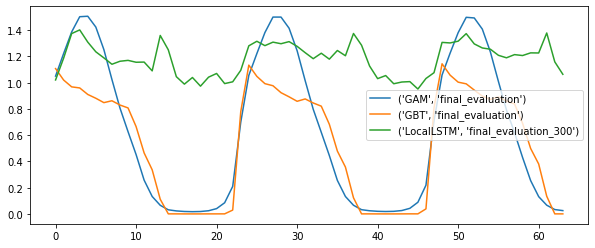

In [148]:
horizon = 64
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_mse.groupby(['model', 'experiment']): 
    grouped = df.groupby(['horizon', 'trial']).rmse.aggregate(np.nanmean).reset_index()
    grouped = grouped.groupby('horizon')
    avg = grouped.rmse.aggregate(np.nanmean).values[-horizon:]
    std = grouped.rmse.aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

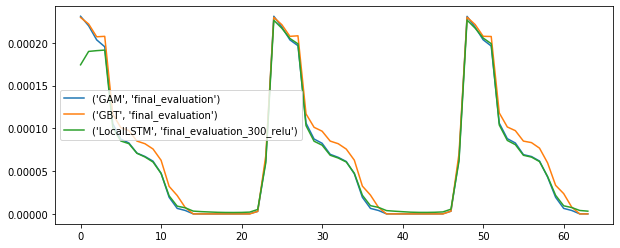

In [331]:
horizon = 64
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_mse.groupby(['model', 'experiment']): 
    grouped = df.groupby(['horizon', 'trial']).rmse.aggregate(np.nanmean).reset_index()
    grouped = grouped.groupby('horizon')
    avg = grouped.rmse.aggregate(np.nanmean).values[-horizon:]
    std = grouped.rmse.aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

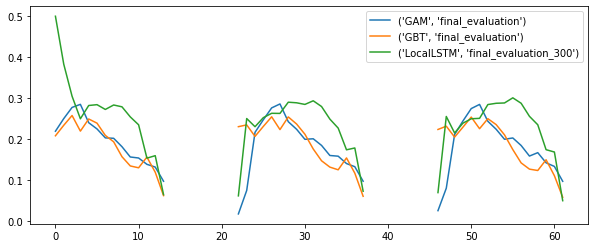

In [126]:
horizon = 64
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_pcc.groupby(['model', 'experiment']): 
    grouped = df.groupby('horizon')
    avg = grouped.prediction_km2.aggregate(np.nanmean).values[-horizon:]
    std = grouped.prediction_km2.aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

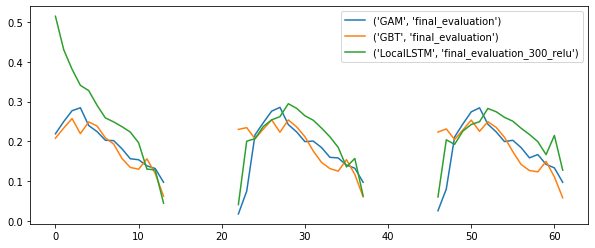

In [332]:
horizon = 64
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_pcc.groupby(['model', 'experiment']): 
    grouped = df.groupby('horizon')
    avg = grouped.prediction_km2.aggregate(np.nanmean).values[-horizon:]
    std = grouped.prediction_km2.aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

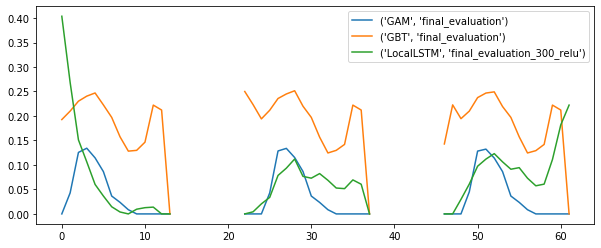

In [333]:
horizon = 64
metric = 'sensitivity'
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_bin.groupby(['model', 'experiment']): 
    grouped = df.groupby('horizon')
    avg = grouped[metric].aggregate(np.nanmean).values[-horizon:]
    std = grouped[metric].aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

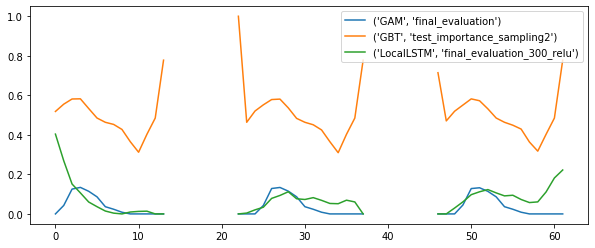

In [328]:
horizon = 64
metric = 'sensitivity'
static_models = ['GAM', 'GBT','LocalMLP']
fig, ax = plt.subplots(figsize=(10,4))
for group, df in df_bin.groupby(['model', 'experiment']): 
    grouped = df.groupby('horizon')
    avg = grouped[metric].aggregate(np.nanmean).values[-horizon:]
    std = grouped[metric].aggregate(np.nanstd).values[-horizon:]
    line = ax.plot(range(avg.size), avg, label=group)#, ls='--', marker='o')
    ax.fill_between(range(avg.size), avg-std, avg+std, color=line[0].get_color(), alpha=0.2)
ax.legend();

In [163]:
b2015 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2015', 'birds_per_seq.npy'))
b2016 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2016', 'birds_per_seq.npy'))
b2017 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2017', 'birds_per_seq.npy'))

idx2015 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2015', 'resampling_idx.npy'))
idx2016 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2016', 'resampling_idx.npy'))
idx2017 = np.load(osp.join(base_dir, 'GBT', 'test_2017', 'test_importance_sampling', '2017', 'resampling_idx.npy'))

In [185]:
print(np.unique(idx2015).size / idx2015.size)
print(np.unique(idx2016).size / idx2016.size)
print(np.unique(idx2017).size / idx2017.size)

0.2912621359223301
0.27184466019417475
0.38665038665038665


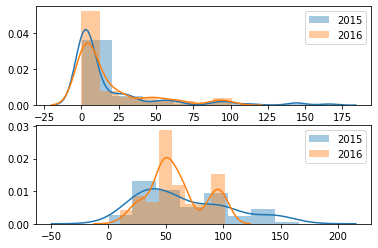

In [167]:
fig, ax = plt.subplots(2, 1)
sb.distplot(b2015, bins=8, ax=ax[0], label='2015')
sb.distplot(b2016, bins=8, ax=ax[0], label='2016')
ax[0].legend()

sb.distplot(b2015[idx2015], bins=8, ax=ax[1], label='2015')
sb.distplot(b2016[idx2016], bins=8, ax=ax[1], label='2016')
ax[1].legend();

In [140]:
b2015.max()

5.841893314617838

28.812529608142828


0.8646647167633873

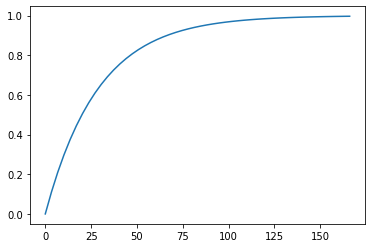

In [228]:
thr = np.quantile(b2015, 0.8)
print(thr)

s = b2015.max()/50
weight_func = lambda x: 1/(1 + np.exp(-(x-thr)/s))
weight_func = lambda x: 1 - np.exp(-x/thr)

xs = np.linspace(0, b2015.max(), 50)
plt.plot(xs, [weight_func(x) for x in xs])
weight_func(2*thr)

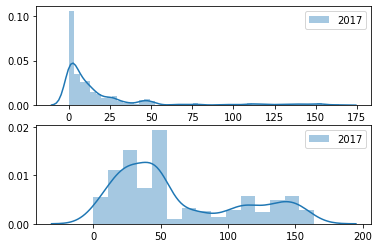

In [136]:
fig, ax = plt.subplots(2, 1)
sb.distplot(b2017, ax=ax[0], label='2017')
ax[0].legend()

sb.distplot(b2017[idx2017], ax=ax[1], label='2017')
ax[1].legend();

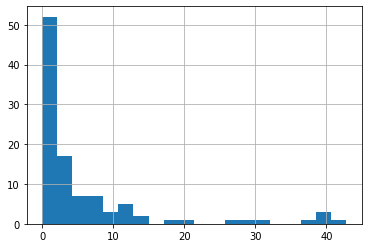

In [184]:
r['LocalLSTM'].groupby('seqID').gt_km2.aggregate(sum).hist(bins=20)

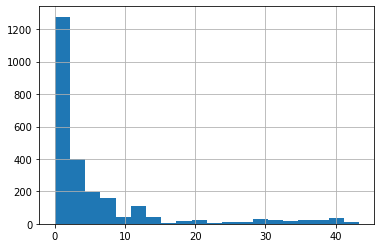

In [62]:
r['GAM'].groupby('seqID').gt_km2.aggregate(sum).hist(bins=20)

7.746284886139805


(-0.1, 1.1)

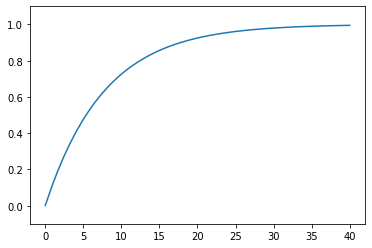

In [307]:
intensity = r['GAM'].groupby('seqID').gt_km2.aggregate(sum).reset_index()
thr = intensity.gt_km2.quantile(0.8)
print(thr)
s = intensity.gt_km2.max()/25
weight_func = lambda x: 1/(1 + np.exp(-(x-thr)/s))
weight_func = lambda x: 1 - np.exp(-x/thr) +0.001
xs = np.linspace(0, 40)
plt.plot(xs, [weight_func(x) for x in xs])
plt.ylim(-0.1,1.1)

In [111]:
idx = np.arange(10) <= 4
np.arange(10)[idx]

array([0, 1, 2, 3, 4])

In [308]:
#weight_func = lambda x: 1/(1 + np.exp(-(x-thr)))
intensity['weight'] = intensity.gt_km2.apply(weight_func)
intensity['weight'] /= intensity['weight'].sum()

In [103]:
intensity = r['GAM'].groupby('seqID').gt_km2.aggregate(sum).reset_index()
intensity['bin'] = pd.cut(intensity.gt_km2, bins=20)
freqs = intensity['bin'].value_counts()
N = freqs.sum()
intensity['weight'] = intensity.bin.apply(lambda x: 1/freqs[x])
intensity['weight'] /= intensity['weight'].sum()

In [309]:
batch = np.random.choice(intensity.gt_km2.values, int(intensity.gt_km2.size*1), p=intensity.weight, replace=True)

In [310]:
index = np.random.choice(np.arange(intensity.gt_km2.size), int(intensity.gt_km2.size*1), p=intensity.weight, replace=True)

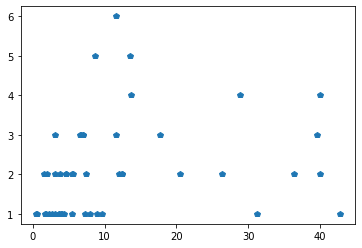

In [311]:
unique, counts = np.unique(index, return_counts=True)
plt.plot(intensity.gt_km2.iloc[unique].values, counts, 'p')
#intensity.gt_km2[~intensity.index.isin(unique)].hist()

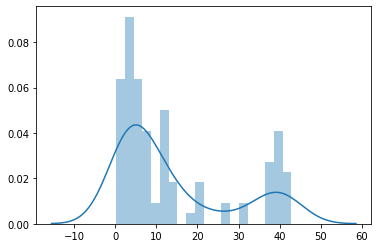

In [312]:
sb.distplot(batch, bins=20)

[Text(0.5, 1.0, '2017-09-22 18:00:00+00:00 - 2017-09-26 09:00:00+00:00')]

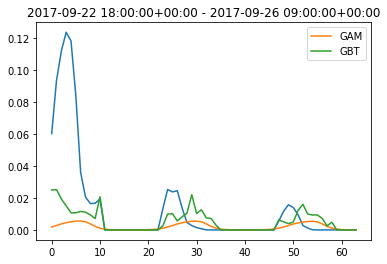

In [35]:
query = 'seqID == 52 & radar == "deess" & trial == 1'
horizon = 64

fig, ax = plt.subplots()

for i, m in enumerate(models.keys()):
    seq = r[m].query(query)
    if i == 0:
        T = seq.gt_km2.size
        ax.plot(range(horizon), seq.gt_km2[-horizon:])
    ax.plot(range(horizon), seq.prediction_km2[-horizon:], label=m)
ax.legend()
ax.set(title=f'{seq.datetime.iloc[0]} - {seq.datetime.iloc[-1]}')

[Text(0.5, 1.0, '2017-08-31 19:00:00+00:00 - 2017-09-04 10:00:00+00:00')]

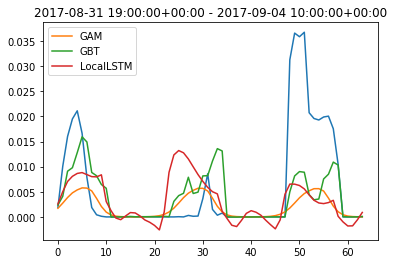

In [217]:
query = 'seqID == 49 & radar == "deess" & trial == 1'
horizon = 64

fig, ax = plt.subplots()

for i, m in enumerate(models.keys()):
    seq = r[m].query(query)
    if i == 0:
        T = seq.gt_km2.size
        ax.plot(range(horizon), seq.gt_km2[-horizon:])
    ax.plot(range(horizon), seq.prediction_km2[-horizon:], label=m)
ax.legend()
ax.set(title=f'{seq.datetime.iloc[0]} - {seq.datetime.iloc[-1]}')

In [68]:
models = {'LocalLSTM': 'final_evaluation_500_decay'}
rseq, _, _, ridx = load_cv_results(models, base_dir, ext='_fixedT0', fluxes=False, trials=1)

/home/fiona/birdMigration/results/abm/LocalLSTM/test_2017/final_evaluation_500_decay/trial_1/results_fixedT0.csv
successfully loaded results for LocalLSTM


In [54]:
rseq['LocalLSTM'].radar.unique()

array(['deemd', 'detur', 'denhb', 'deboo', 'deros', 'deisn', 'deess',
       'dehnr', 'nldbl', 'demem', 'deeis', 'bewid', 'deoft', 'bejab',
       'deneu', 'defld', 'bezav', 'depro', 'nldhl', 'defbg', 'dedrs',
       'deumd', 'chalb', 'chwei', 'chlem', 'chppm', 'chdol', 'frmtc',
       'frnan', 'frtro', 'frave', 'frabb', 'frtra', 'frbla', 'frniz',
       'frcae', 'frpla', 'frtre', 'frche', 'frbou', 'frlep', 'frgre',
       'frbor', 'frmom', 'frtou', 'fropo', 'frmcl', 'frnim', 'frbol'],
      dtype=object)

(66,)


[Text(0.5, 1.0, '2017-09-28 18:00:00+00:00 - 2017-10-02 09:00:00+00:00')]

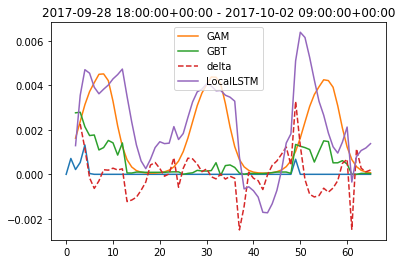

In [218]:
query = 'seqID == 58 & radar == "deumd" & trial == 1'
horizon = 66

fig, ax = plt.subplots()

for i, m in enumerate(models.keys()):
    seq = r[m].query(query)
    if i == 0:
        T = seq.gt_km2.size
        ax.plot(range(horizon), seq.gt_km2[-horizon:])
    if m == 'LocalLSTM':
        delta = seq.prediction_km2[-horizon:].values - seq.prediction_km2[-horizon-1:-1].values
        print(delta.shape)
        ax.plot(range(horizon), delta, label='delta', ls='--')
    ax.plot(range(horizon), seq.prediction_km2[-horizon:], label=m)
ax.legend()
ax.set(title=f'{seq.datetime.iloc[0]} - {seq.datetime.iloc[-1]}')

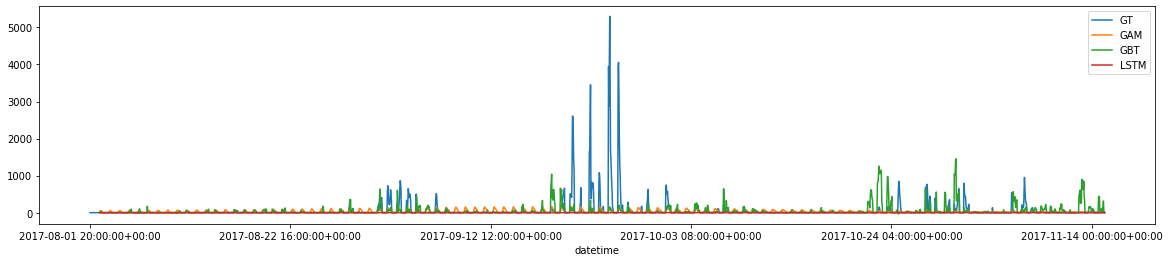

In [101]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'frniz'
r['GAM'].query(f'radar == "{radar}"').groupby('datetime').gt.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['GAM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='GAM')
r['GBT'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='GBT')
r['LocalLSTM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='LSTM')
ax.legend()

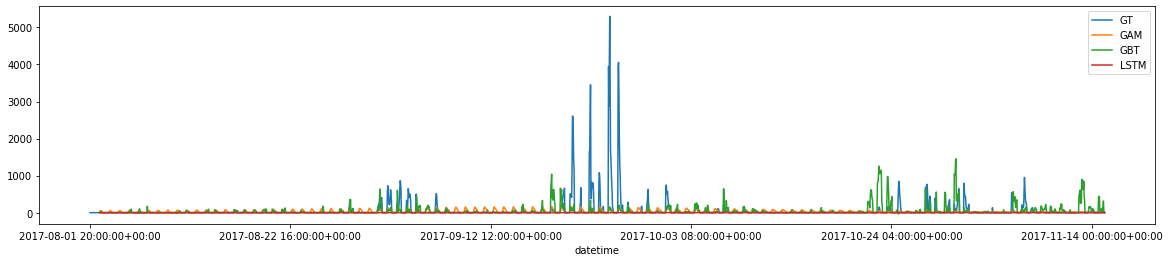

In [334]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'frniz'
r['GAM'].query(f'radar == "{radar}"').groupby('datetime').gt.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['GAM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='GAM')
r['GBT'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='GBT')
r['LocalLSTM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='LSTM')
ax.legend()

In [226]:
r['LocalLSTM'].query(f'radar == "{radar}"').datetime.unique().size

1231

In [227]:
r['GAM'].query(f'radar == "{radar}"').datetime.unique().size

2533

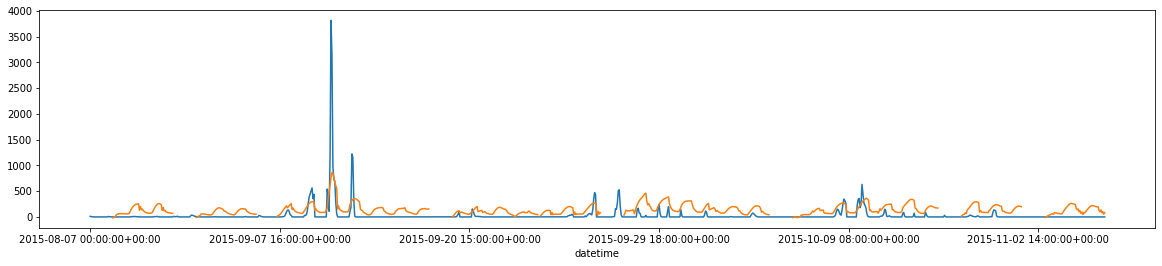

In [320]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'defbg'
r['FluxGraphLSTM'].query(f'radar == "{radar}"').groupby('datetime').gt.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['FluxGraphLSTM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='Flux')

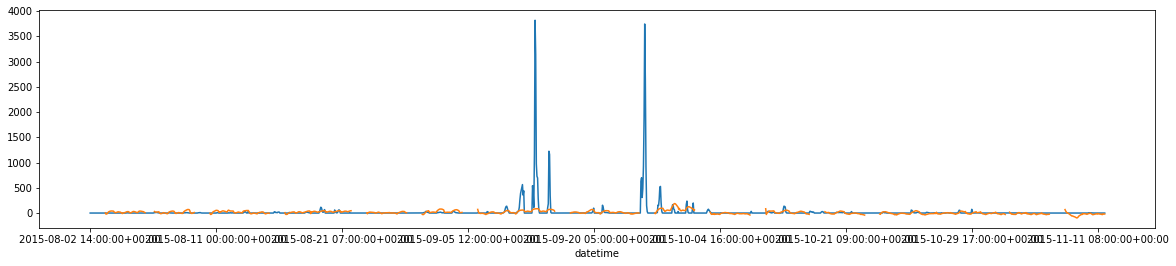

In [322]:
fig, ax = plt.subplots(figsize=(20,4))
radar = 'defbg'
r['FluxGraphLSTM'].query(f'radar == "{radar}"').groupby('datetime').gt.aggregate(np.nanmean).plot(ax=ax, label='GT')
r['FluxGraphLSTM'].query(f'radar == "{radar}"').groupby('datetime').prediction.aggregate(np.nanmean).plot(ax=ax, label='Flux')